In [56]:
import pandas as pd
import numpy as np
import os
import datetime
from scipy.stats import binned_statistic_2d, binned_statistic

In [2]:
#получаем список файлов данных
dataDir = "//NAS-STORAGE/data/TLCYellowData"
fileList = os.listdir(dataDir)
rawDataFiles = filter(lambda x: x.endswith('.csv'), fileList)

#читаем список районов
regions = pd.read_csv("regions.csv", sep = ';')

In [48]:
def GetRegion(longitude, latitude, regionsTable=regions):
    val = regionsTable.region[(regions.west < longitude)&(regions.east >= longitude)&
               (regions.north > latitude)&(regions.south <= latitude)].values
    if len(val)>0:
        return val[0]
    else:
        return 3000
    
def EvalRegion(longitude, latitude):
    deltaX = (74.25559-73.70001)/50
    deltaY = (40.91553-40.49612)/50
    X = abs(np.ceil((74.25559 + longitude)/deltaX))-1
    Y = np.ceil((latitude - 40.49612)/deltaY)
    res = int(X*50 + Y)
    if ((res > 2500)|(res < 0)):
        return 3000
    else:
        return res
    
def SkipMinSec(timestamp):
    return np.datetime64(timestamp, 'h')

def PrepareData(dataFrame, regionsTable=regions):
    
    #извлекаем имена используемых колонок по их индексам, т.к. их названия меняются в разных файлах
    pickupTimeCol = rawData.columns[1]
    dropoffTimeCol = rawData.columns[2]
    passengerCountCol = rawData.columns[3]
    tripDistanceCol = rawData.columns[4]
    pickupLongitudeCol = rawData.columns[5]
    pickupLatitudeCol = rawData.columns[6]
    dropoffLongitudeCol = rawData.columns[9]
    dropoffLatitudeCol = rawData.columns[10]
    totalAmountCol = rawData.columns[17]
    
    
    #преобразуем колонки времени начала и окончания поездки в формат datetime64
    rawData[pickupTimeCol] = pd.to_datetime(rawData[pickupTimeCol])
    rawData[dropoffTimeCol] = pd.to_datetime(rawData[dropoffTimeCol])

    #исключаем поездки с нулевой длительностью
    #delIndexes = dataFrame[dataFrame[pickupTimeCol] == dataFrame[dropoffTimeCol]].index
    #dataFrame.drop(dataFrame.index[delIndexes], inplace=True) 
    dataFrame = dataFrame[dataFrame[pickupTimeCol] < dataFrame[dropoffTimeCol]]

    #исключаем поездки с нулевым количеством пассажиров
    #delIndexes = dataFrame[dataFrame[passengerCountCol] == 0].index
    #dataFrame.drop(delIndexes, inplace=True) 
    dataFrame = dataFrame[dataFrame[passengerCountCol] > 0]

    #исключаем поездки с нулевым расстоянием по счетчику
    #delIndexes = dataFrame[dataFrame[tripDistanceCol] == 0].index
    #dataFrame.drop(delIndexes, inplace=True)
    dataFrame = dataFrame[dataFrame[tripDistanceCol] > 0]
    
    #исключаем поездки не из заданого квадрата
    #delIndexes = dataFrame[((dataFrame[pickupLongitudeCol] < -74.25559)|(dataFrame[pickupLongitudeCol] > -73.70001)|
    #                      (dataFrame[pickupLatitudeCol] < 40.49612)|(dataFrame[pickupLatitudeCol] > 40.91553))].index    
    #dataFrame.drop(delIndexes, inplace=True)
    dataFrame = dataFrame[((dataFrame[pickupLongitudeCol] >= -74.25559)&(dataFrame[pickupLongitudeCol] <= -73.70001)&
                          (dataFrame[pickupLatitudeCol] >= 40.49612)&(dataFrame[pickupLatitudeCol] <= 40.91553))]
    
    #delIndexes = dataFrame[((dataFrame[dropoffLongitudeCol] < -74.25559)|(dataFrame[dropoffLongitudeCol] > -73.70001)|
    #                      (dataFrame[dropoffLatitudeCol] < 40.49612)|(dataFrame[dropoffLatitudeCol] > 40.91553))].index    
    #dataFrame.drop(delIndexes, inplace=True)
    dataFrame = dataFrame[((dataFrame[dropoffLongitudeCol] >= -74.25559)&(dataFrame[dropoffLongitudeCol] <= -73.70001)&
                          (dataFrame[dropoffLatitudeCol] >= 40.49612)&(dataFrame[dropoffLatitudeCol] <= 40.91553))]    
    
    #определяем район посадки пассажиров для каждой записи
    dataFrame['region'] = map(EvalRegion, dataFrame[pickupLongitudeCol],dataFrame[pickupLatitudeCol])
    
    #определяем район высадки пассажиров для каждой записи
    dataFrame['dropoff_region'] = map(EvalRegion, dataFrame[dropoffLongitudeCol],dataFrame[dropoffLatitudeCol])
    #удаляем минуты и секунды из времени начала и окончания поездки
    dataFrame[pickupTimeCol] = dataFrame[pickupTimeCol].apply(SkipMinSec)
    dataFrame[dropoffTimeCol] = dataFrame[dropoffTimeCol].apply(SkipMinSec)
    
    #возвращаем значения параметров x, y для подсчета статистики
    #return dataFrame[pickupTimeCol].values.astype(np.int64), dataFrame.region.values
    
    #возвращаем весь датафрейм для подсчета разных статистик
    return dataFrame

In [4]:
#JFK Airport
print GetRegion(-73.787076, 40.642454)

2118


# Чтение файла по частям

In [71]:
#filename = 'yellow_tripdata_2016-05.csv'
    #dataLen = 0
    
print "Обработка началась ", datetime.datetime.now()

for filename in rawDataFiles:    
    #будем читать записи порциями
    rawDataReader = pd.read_csv(dataDir + '/' + filename, chunksize=1000000)

    #создаем список меток времени по количеству часов в текущем месяце
    currentDate = filename.replace('yellow_tripdata_','').replace('.csv','')
    currentDate = pd.to_datetime(currentDate)
    timestamps = pd.date_range(currentDate, periods = currentDate.days_in_month*24, freq='H')

    #массив для накопления статистики
    cummulativeTripsFromRegion = np.zeros([timestamps.shape[0], regions.shape[0]])
    cummulativeTripsToRegion = np.zeros([timestamps.shape[0], regions.shape[0]])
    cummulativePassengers = np.zeros([timestamps.shape[0], regions.shape[0]])
    cummulativeAmount = np.zeros([timestamps.shape[0], regions.shape[0]])

    for rawData in rawDataReader:        

        #x,y = PrepareData(rawData)    
        preparedData = PrepareData(rawData)

        #считаем количество поездок из каждого района      
        additionalHour = (timestamps[-1] + datetime.timedelta(hours=1)).to_datetime64().astype(np.int64)
        xBins = np.hstack([timestamps.astype(np.int64), additionalHour])
        yBins = np.hstack([regions.region, 2501])

        #x = preparedData[preparedData.columns[1]].values.astype(np.int64)
        #y = preparedData.region.values

        #cummulativeTripsFromRegion += binned_statistic_2d(x, y, None, 'count', [xBins, yBins]).statistic

        #считаем количество поездок в каждый район
        x = preparedData[preparedData.columns[2]].values.astype(np.int64)
        y = preparedData.dropoff_region.values        

        cummulativeTripsToRegion += binned_statistic_2d(x, y, None, 'count', [xBins, yBins]).statistic 

        #считаем количество пассажиров, перевезенных из района за каждый час
        x = preparedData[preparedData.columns[1]].values.astype(np.int64)
        y = preparedData.region.values    

        val = preparedData[preparedData.columns[3]].values

        cummulativePassengers += binned_statistic_2d(x, y, val, 'sum', [xBins, yBins]).statistic

        #считаем общую стоимость поездок из района за каждый час
        val = preparedData[preparedData.columns[17]].values

        cummulativeAmount += binned_statistic_2d(x, y, val, 'sum', [xBins, yBins]).statistic

    #Сохраняем результат
    #tripsFromRegion = pd.DataFrame(data = cummulativeTripsFromRegion, index = timestamps, columns = regions.region, dtype=int)
    #tripsFromRegion.to_csv(filename.replace('yellow_tripdata_','trip_count_'))

    tripsToRegion = pd.DataFrame(data = cummulativeTripsToRegion, index = timestamps, columns = regions.region, dtype=int)
    tripsToRegion.to_csv(filename.replace('yellow_tripdata_','trip_to_region_count_'))

    passengersCount = pd.DataFrame(data = cummulativePassengers, index = timestamps, columns = regions.region, dtype=int)
    passengersCount.to_csv(filename.replace('yellow_tripdata_','passengers_count_'))

    amount = pd.DataFrame(data = cummulativeAmount, index = timestamps, columns = regions.region, dtype=int)
    amount.to_csv(filename.replace('yellow_tripdata_','amount_'))

    print "%s: Файл %s обработан."%(datetime.datetime.now(), filename)
    #print "Количество записей после фильтрации: ",dataLen
    
print "Обработка завершена в ", datetime.datetime.now()

Обработка началась  2017-07-03 13:24:08.401000
2017-07-03 13:52:22.033000: Файл yellow_tripdata_2014-01.csv обработан.
2017-07-03 14:20:56.483000: Файл yellow_tripdata_2014-06.csv обработан.


C:\Program Files\Anaconda2\lib\site-packages\IPython\core\interactiveshell.py:2821: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


2017-07-03 14:48:16.681000: Файл yellow_tripdata_2014-02.csv обработан.
2017-07-03 15:20:17.700000: Файл yellow_tripdata_2014-03.csv обработан.
2017-07-03 15:50:25.414000: Файл yellow_tripdata_2014-04.csv обработан.
2017-07-03 16:20:51.918000: Файл yellow_tripdata_2014-05.csv обработан.
2017-07-03 16:48:04.953000: Файл yellow_tripdata_2014-12.csv обработан.
2017-07-03 17:14:33.994000: Файл yellow_tripdata_2014-08.csv обработан.
2017-07-03 17:41:41.778000: Файл yellow_tripdata_2014-07.csv обработан.
2017-07-03 18:09:49.724000: Файл yellow_tripdata_2014-11.csv обработан.
2017-07-03 18:37:15.395000: Файл yellow_tripdata_2014-09.csv обработан.
2017-07-03 19:06:50.894000: Файл yellow_tripdata_2014-10.csv обработан.
2017-07-03 19:35:31.423000: Файл yellow_tripdata_2013-02.csv обработан.
2017-07-03 20:08:25.512000: Файл yellow_tripdata_2013-03.csv обработан.
2017-07-03 20:40:01.012000: Файл yellow_tripdata_2013-04.csv обработан.
2017-07-03 21:10:22.376000: Файл yellow_tripdata_2013-01.csv обр

# п. 4

In [32]:
resultTable.head()

region,1,2,3,4,5,6,7,8,9,10,...,2491,2492,2493,2494,2495,2496,2497,2498,2499,2500
2016-05-01 00:00:00,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2016-05-01 01:00:00,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2016-05-01 02:00:00,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2016-05-01 03:00:00,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2016-05-01 04:00:00,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# п. 5

In [33]:
EmpireStateBuildingLong = -73.985594
EmpireStateBuildingLat = 40.748411
ESBRegion = EvalRegion(EmpireStateBuildingLong, EmpireStateBuildingLat)
print "В мае 2016 из района дислокации Empire state building (%d) было совершено %d поездок."%(ESBRegion, resultTable[ESBRegion].sum())

В мае 2016 из района дислокации Empire state building (1231) было совершено 489489 поездок.


Populating the interactive namespace from numpy and matplotlib


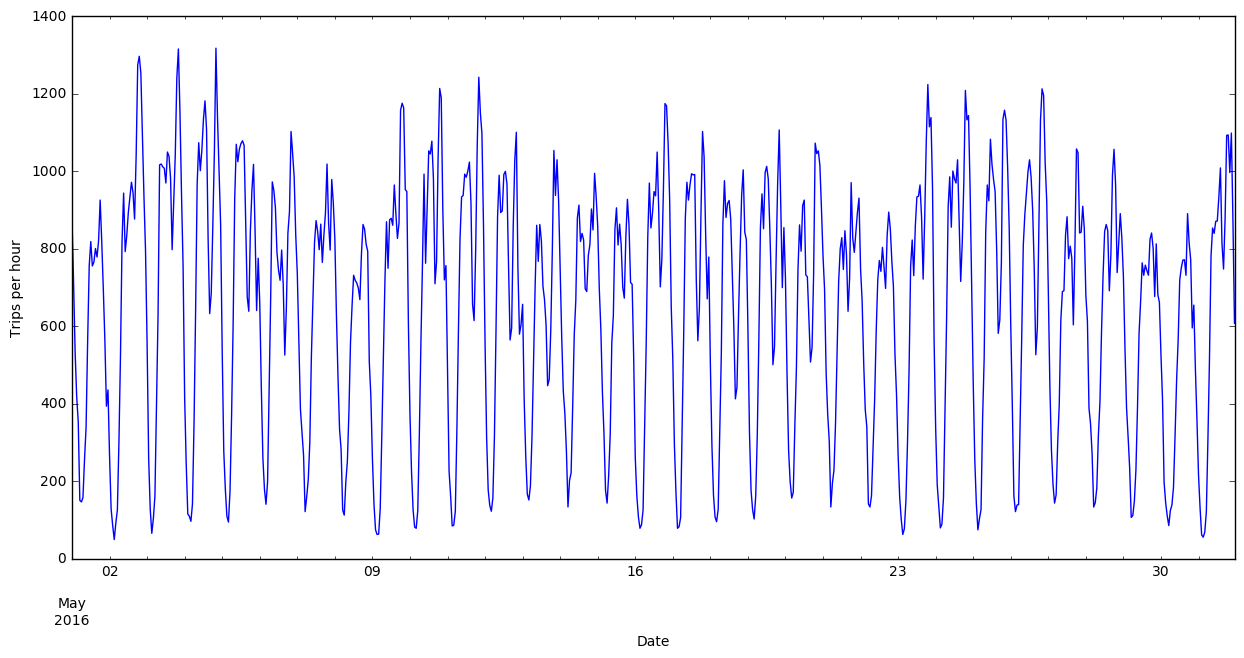

In [34]:
%pylab inline
import matplotlib.pyplot as plt

plt.figure(figsize(15,7))
resultTable[(EvalRegion(EmpireStateBuildingLong, EmpireStateBuildingLat))].plot()
plt.ylabel('Trips per hour')
plt.xlabel('Date')
pylab.show()

# п. 6

In [10]:
%%time
zeroVals=0
for i in xrange(1,2501):
    zeroVals += resultTable[resultTable[i] == 0].shape[0]
        
print "Количество нулевых пар: ", zeroVals, " из ", resultTable.size

Количество нулевых пар:  1665094  из  1800000
Wall time: 10.7 s
